# 1. 기본 설정

## (1) 라이브러리

In [1]:
import time
start_time = time.time()
import os

# 데이터 로드

import cv2
import numpy as np
import matplotlib.pyplot as plt

# 데이터 전처리
import tensorflow as tf

# Data augmentation
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

# 훈련
from tensorflow import data

# 생성자 구성
from tensorflow.keras import layers, Input, Model

# 학습 및 테스트
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from IPython import display
import random

## (2) 파라미터 설정

In [2]:
# 파라미터
# 배치 수
num_mini_batch = 4

# Encoder
enc_kernel_size = 4
enc_strides = 2
enc_filters = [64,128,256,512,512,512,512,512]
enc_alpha_lrelu = 0.2

# Decoder
dropout = True
ratio_dropout = .5
dec_kernel_size = 4
dec_strides = 2
dec_filters = [512,512,512,512,256,128,64]
dec_alpha_lrelu = 0.2

# Discriminator
disc_kernel_size = 4
disc_strides = 2
disc_alpha_lrelu = 0.2
gene_lr = 2e-4
gene_beta_1 = .5
gene_beta_2 = .999
disc_lr = 2e-4
disc_beta_1 = .5
disc_beta_2 = .999

# Train
save_every = 10
EPOCHS = 41


## (3) 데이터 로드 및 확인

In [3]:
home_path = r'C:/Users/user/Desktop/AIFFEL/Exp17/cityscapes'

# 데이터 개수 확인
data_path = os.path.join(home_path + '/train/')
print("number of train examples :", len(os.listdir(data_path)))

# 기록 및 체크포인트 경로 설정
sample_path = os.path.join(home_path+'/sample/sample_epoch_{:04d}_iter_{:03d}.png')
history_path = os.path.join(home_path + '/training_history/train_history_{:04d}.png')
checkpoint_path = os.path.join(home_path+'/training_checkpoints')


number of train examples : 1000


In [4]:
# 예시 데이터의 쉐입 파악
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


## (4) 데이터 전처리

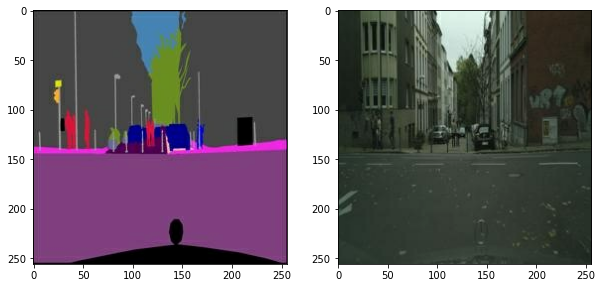

In [5]:
def normalize(x):
    
    # 텐서 플로우 데이터로 캐스트.
    x = tf.cast(x, tf.float32)
    # 데이터 구간을 (0,255) -> (-1, 1)로 변경
    return (x/127.5) - 1

def denormalize(x):
    
    # 데이터 구간을 (-1, 1) -> (0, 255)로 변경
    x = (x+1)*127.5
    # 데이터를 텐서플로우 데이터 -> numpy 데이터로 변환.
    x = x.numpy()
    
    # 데이터를 일반 정수로 반환.
    return x.astype(np.uint8)

def load_img(img_path):
    
    # 지정 경로로부터 파일 읽기
    img = tf.io.read_file(img_path)
    # 읽어온 이미지 파일을 적절한 텐서타입으로 변경, 3 = 채널 수(RGB)
    img = tf.image.decode_image(img, 3)
    
    # 너비 = 이미지 너비의 절반.
    w = tf.shape(img)[1] // 2
    
    # 스케치: 이미지의 뒤 절반.
    sketch = img[:, w:, :]
    # 읽어온 이미지를 tf 타입으로 캐스트
    sketch = tf.cast(sketch, tf.float32)
    
    # 컬러: 이미지의 앞 절반
    colored = img[:, :w, :]
    # 읽어온 이미지를 tf 타입으로 캐스트.
    colored = tf.cast(colored, tf.float32)
    
    # 스케치와 컬러를 정규화시켜 반환.
    return normalize(sketch), normalize(colored)

#데이터 경로 지정 및 로드
f = data_path+ os.listdir(data_path)[1]
sketch, colored = load_img(f)

# 로딩확인: 스케치와 컬러이미지 분리
plt.figure(figsize = (10, 7))
plt.subplot(1, 2, 1); plt.imshow(denormalize(sketch))
plt.subplot(1, 2, 2); plt.imshow(denormalize(colored))

In [6]:
# data augmentation
@tf.function()  # 빠른 텐서플로우 연산을 위해 사용.
def apply_augmentation(sketch, colored):
    
    # 두 이미지가 채널 축으로 연결됨. 각각 3채널인 경우 6채널이 된다.
    stacked = tf.concat([sketch, colored], axis = -1)
    
    _pad = tf.constant([[30, 30], [30, 30], [0, 0]])
    
    # 각 50%의 확률로 Reflection padding 또는 constant padding이 30픽셀의 pad width만큼 적용된다.
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values = 1.)
        
    # (256, 256, 6) 크기를 가진 이미지를 임의로 잘라낸다.    
    out = image.random_crop(padded, size = [256, 256, 6])
    
    # 결과를 50% 확률로 좌우 반전
    out = image.random_flip_left_right(out)
    
    # 결과를 50% 확률로 상하 반전
    out = image.random_flip_up_down(out)
    
    # 결과를 50% 확률로 90도 회전
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval = 1, maxval = 4, dtype = tf.int32)
        out = image.rot90(out, k = degree)
        
    return out[..., :3], out[..., 3:]


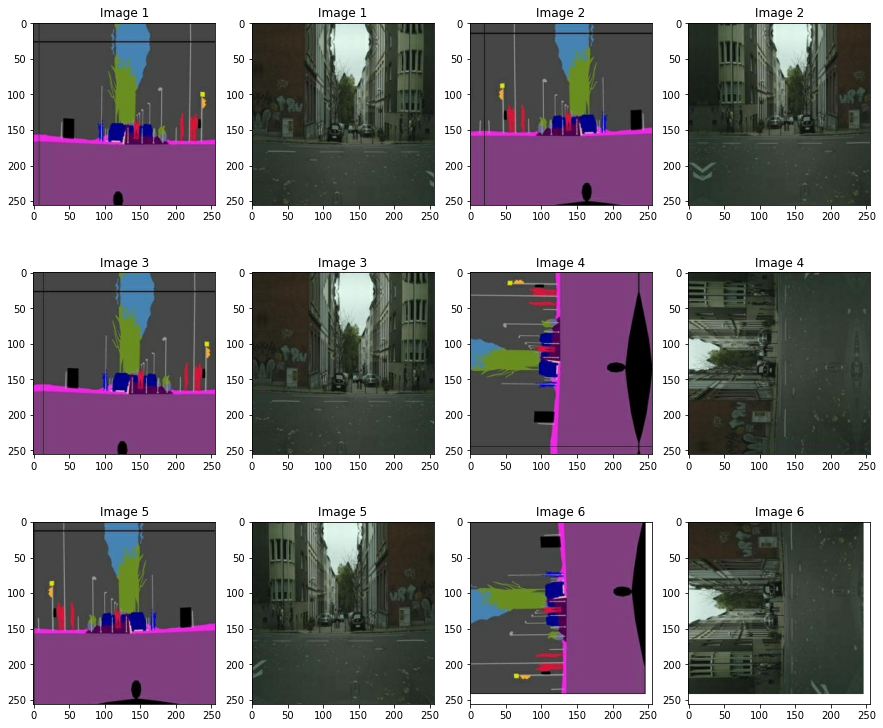

In [7]:
plt.figure(figsize = (15, 13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    # 보강된 이미지를 원복하여 출력. 보강 여부 확인.
    plt.subplot(3, 4, i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}") 
    plt.subplot(3, 4, i+1);
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1
                             

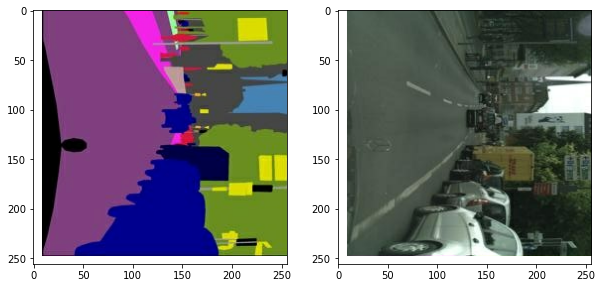

In [8]:
# 이미지를 불러와서 강화하여 반환.
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

# 패턴이 매칭되는 이미지들로 데이터셋을 만듬.
train_images = data.Dataset.list_files(data_path + "*.jpg")
# 이미지 데이터셋에 이미지를 불러와 강화하여 반환하고 섞는다. 미니 배치 구성까지.
train_images = train_images.map(get_train).shuffle(100).batch(num_mini_batch)

# 변화 이미지 체크
sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# 2. 생성자 구성

## (1) 인코더, 디코더 정의

In [9]:
# 컨벌루션, 배치 정규화, LeakyReLU 활성함수로 정의된 인코딩 블럭을 정의
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn
        
        # convolution layer 정의
        self.conv = layers.Conv2D(n_filters, enc_kernel_size, enc_strides, "same", use_bias=False)
        
        # 배치 정규화
        self.batchnorm = layers.BatchNormalization()
        
        # Leaky relu 활성함수
        self.lrelu= layers.LeakyReLU(enc_alpha_lrelu)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

# 드롭아웃, 전치 컨벌루션, 배치 정규화, LeakyReLU 활성함수로 정의된 디코딩 블럭을 정의.
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        
        # 드롭아웃 여부 (True/False)
        self.dropout = dropout
        
        # 전치 컨벌루션
        self.Transconv = layers.Conv2DTranspose(f, dec_kernel_size, dec_strides, "same", use_bias=False)
        
        # 배치 정규화
        self.batchnorm = layers.BatchNormalization()
        
        # 활성함수: LeakyReLU
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(ratio_dropout)(x)
        return self.relu(x)


In [10]:
# 인코더 정의. 층 수는 필터 수에 따라 결정됨.
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = enc_filters
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


enc_model = Encoder()
enc_model.get_summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encode_block (EncodeBlock)  (None, 128, 128, 64)      3072      
                                                                 
 encode_block_1 (EncodeBlock  (None, 64, 64, 128)      131584    
 )                                                               
                                                                 
 encode_block_2 (EncodeBlock  (None, 32, 32, 256)      525312    
 )                                                               
                                                                 
 encode_block_3 (EncodeBlock  (None, 16, 16, 512)      2099200   
 )                                                               
                                                             

In [11]:
# 디코더 정의. 층 수는 필터 수에 따라 결정됨.    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = dec_filters
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, dec_kernel_size, dec_strides, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

dec_model = Decoder()
dec_model.get_summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 512)]       0         
                                                                 
 decode_block (DecodeBlock)  (None, 2, 2, 512)         4196352   
                                                                 
 decode_block_1 (DecodeBlock  (None, 4, 4, 512)        4196352   
 )                                                               
                                                                 
 decode_block_2 (DecodeBlock  (None, 8, 8, 512)        4196352   
 )                                                               
                                                                 
 decode_block_3 (DecodeBlock  (None, 16, 16, 512)      4196352   
 )                                                               
                                                           

## (2) 생성자 정의: UNet 생성자

In [12]:
# UNet generator
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = enc_filters
        decode_filters = dec_filters
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, dec_kernel_size, dec_strides, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()



generator = UNetGenerator()
generator.get_summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_8 (EncodeBlock)   (None, 128, 128, 64  3072        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_9 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block_8[0][0]']         
                                                                                            

# 3. 판별자 구성하기

## (1) 판별자 블럭 정의

In [13]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=disc_strides, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, disc_kernel_size, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, disc_kernel_size, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(disc_alpha_lrelu) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

# 샘플 입력값, 출력값 설정
inputs = Input((128,128,32))
# 출력값: 입력값에 0패딩을 붙인다.
out = layers.ZeroPadding2D()(inputs)
# 출력값을 컨벌루션한다.
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
# 출력값을 배치 정규화한다.
out = layers.BatchNormalization()(out)
# 출력값을 활성함수로 보내 출력시킨다.
out = layers.LeakyReLU(disc_alpha_lrelu)(out)

# 입력값과 출력값을 판별한다.
disc_model = Model(inputs, out)
disc_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 130, 130, 32)     0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_30 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable

## (2) 판별자 정의

In [14]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        
        # 최종 출력은 sigmoid 활성함수를 통해 출력된다.
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
discriminator = Discriminator()
discriminator.get_summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_5[0][0]',                
                                                                  'input_6[0][0]']          

# 4. 훈련

In [15]:
# 손실함수 계산
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

# 생성 손실함수 계산
def get_gene_loss(fake_output, real_output, fake_disc):
    
    # L1 손실은 실제 결과와 생성 결과의 mae.
    l1_loss = mae(real_output, fake_output)
    
    # 생성 손실은 가짜 판별결과와 가짜 판별자 크기의 1행렬 간의 bce.
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

# 판별 손실함수 계산
def get_disc_loss(fake_disc, real_disc):
    
    # 판별 손실은 가짜 판별결과와 가짜 판별자 크기의 0행렬 간의 bce와
    # 진짜 판별결과와 진짜 판별자 크기의 1행렬 간의 bce의 합    
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

# 옵티마이저 설정
gene_opt = optimizers.Adam(gene_lr, beta_1=gene_beta_1, beta_2=gene_beta_2)
disc_opt = optimizers.Adam(disc_lr, beta_1=disc_beta_1, beta_2=disc_beta_2)

# 사용할 생성자와 판별자 선택
generator = generator # UNet 고정
discriminator = discriminator  # 고정.


In [16]:
# 훈련 함수 정의
@tf.function
def train_step(sketch, real_colored): # 입력으로 2개를 받는다는 점이 기존과 다름.
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:

        # Generator 예측
        fake_colored = generator(sketch, training=True)

        # 가짜 판별은 스케치에 가짜 컬러를 입힌 것에 대한 판별 결과
        fake_disc = discriminator(sketch, fake_colored, training=True)
        # 진짜 판별은 스케치에 진짜 컬러를 입힌 것에 대한 판별 결과
        real_disc = discriminator(sketch, real_colored, training=True)

        # 생성 손실, L1 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)

        # 생성 손실에 L1 손실에 lambda를 곱한 값을 더해 최종 생성 손실을 계산.
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100

        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
    
    # 생성자 그래디언트에 생성 종합 손실과 이 때의 생성 훈련변수 그래디언트를 기록
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    # 판별자 그래디언트에 판별 손실과 이 때의 판별 훈련변수 그래디언트를 기록
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # 생성자 그래디언트와 생성 훈련변수를 새 그래디언트에 반영하여 생성자 최적화.
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    # 판별자 그래디언트와 판별 훈련변수를 새 그래디언트에 반영하여 판별자 최적화.
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    
    # 생성 손실, L1 손실, 판별 손실 출력
    return gene_loss, l1_loss, disc_loss  

In [17]:
# 손실 함수 기록
def draw_train_history(history, epoch):

    plt.figure(figsize=(10,5))
    plt.plot(history['gen_loss'])
    plt.plot(history['L1_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'L1_loss', 'disc_loss'], loc = 'upper left')

    # training_history 디렉토리에 epoch별 손실 함수 그래프를 이미지 파일로 저장.
    plt.savefig(history_path.format(epoch))
    plt.show()

    
# training_checkpoint 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈 설정
checkpoint_prefix = os.path.join(checkpoint_path, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer = gene_opt,
                                 discriminator_optimizer = disc_opt,
                                 generator = generator,
                                 discriminator = discriminator)

# 최근의 체크포인트 경로
latest = tf.train.latest_checkpoint(checkpoint_path)
# 최근의 체크포인트 복원
checkpoint.restore(latest)

# 생성자에 대해 불러온 체크포인트값 입력
generator = checkpoint.generator
# 판별자에 대해 불러온 체크포인트값 입력
discriminator = checkpoint.discriminator

In [18]:
def train(sketch, colored, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'L1_loss':[], 'disc_loss':[]}
    
    for epoch in range(1, EPOCHS+1):
        
        for i, (sketch, colored) in enumerate(train_images):
            g_loss, l1_loss, d_loss = train_step(sketch, colored)
            history['gen_loss'].append(g_loss)
            history['L1_loss'].append(l1_loss)
            history['disc_loss'].append(d_loss)
                    
            # 10회 반복마다 손실을 출력합니다.
            if (i+1) % 10 == 0:
                display.clear_output(wait = True)
                print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                        \nGenerator_loss:{g_loss.numpy():.4f} \
                        \nL1_loss:{l1_loss.numpy():.4f} \
                        \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
        
        # 체크 포인트 저장
        if (epoch +1) % save_every == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
                        
        display.clear_output(wait = True)
        draw_train_history(history, epoch)

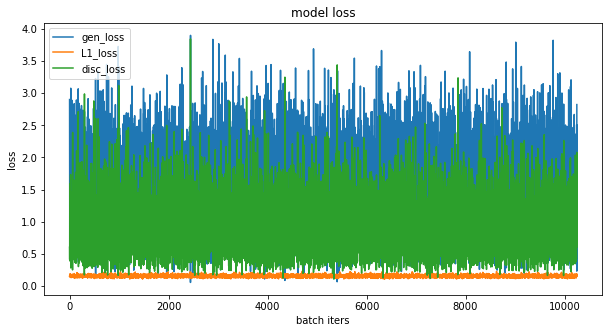

Wall time: 27min 20s


In [19]:
%%time
train(sketch, colored, EPOCHS, save_every)

# 5. 평가

훈련 EPOCHS 수: 41


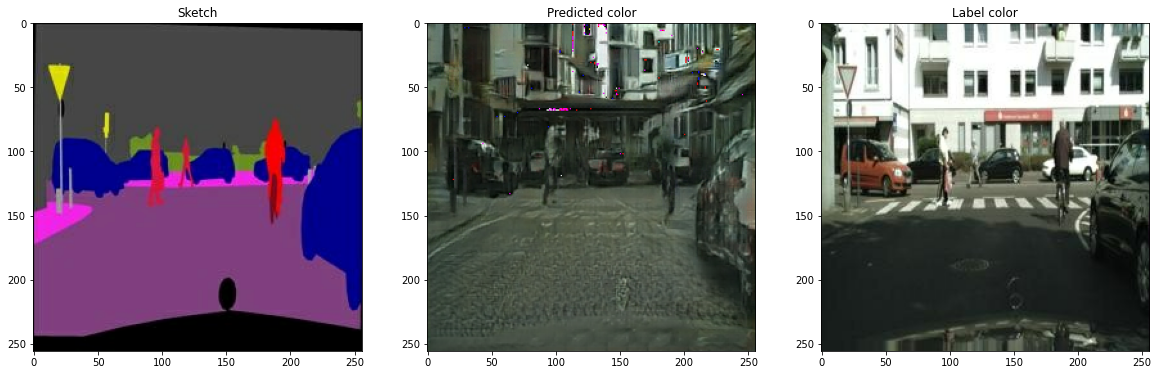

In [20]:
# 학습결과 평가
test_ind = random.randrange(1,6)  # 5장 중 무작위로 1장을 골라 평가를 진행.
val_path =  os.path.join(home_path + '/val/')
f = val_path + os.listdir(val_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

print('훈련 EPOCHS 수: {}'.format(EPOCHS))
plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch)); plt.title(f'Sketch')
plt.subplot(1,3,2); plt.imshow(pred[0]); plt.title(f'Predicted color')
plt.subplot(1,3,3); plt.imshow(denormalize(colored)); plt.title(f'Label color')

val_save_path = os.path.join(home_path+'/sample/{}EPOCHS_pred_{}.png') # 출력된 그림을 저장.
plt.savefig(val_save_path.format(EPOCHS, test_ind))
plt.show()

In [21]:
end_time = time.time()
work_time = int((end_time - start_time)//60)

print("총 작업시간: 약 {}분".format(work_time))
print("***모든 작업 완료***")


총 작업시간: 약 27분
***모든 작업 완료***


# 회고
- EXP10의 GAN 이미지 생성에서 사용했던 체크포인트 및 저장 코드를 일부 가져와 적용하였다. 리소스 부족 등으로 발생하는 에러에도 손실이 적게 되어 매우 만족.
- augmentation은 예제에서 나온 코드가 3가지 이상으로, 충분히 많은 결과라 생각되어 굳이 더 늘리지 않았다.
- 파라미터는 별도로 손대지 않고 EPOCHS 수만 늘려서(총 500회) 제법 만족스러운 결과를 얻을 수 있었다.
- < 450 번째의 히스토리 >
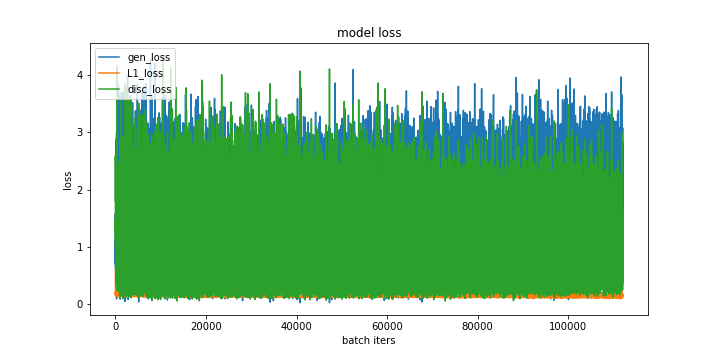

< 450 번째의 이미지 >
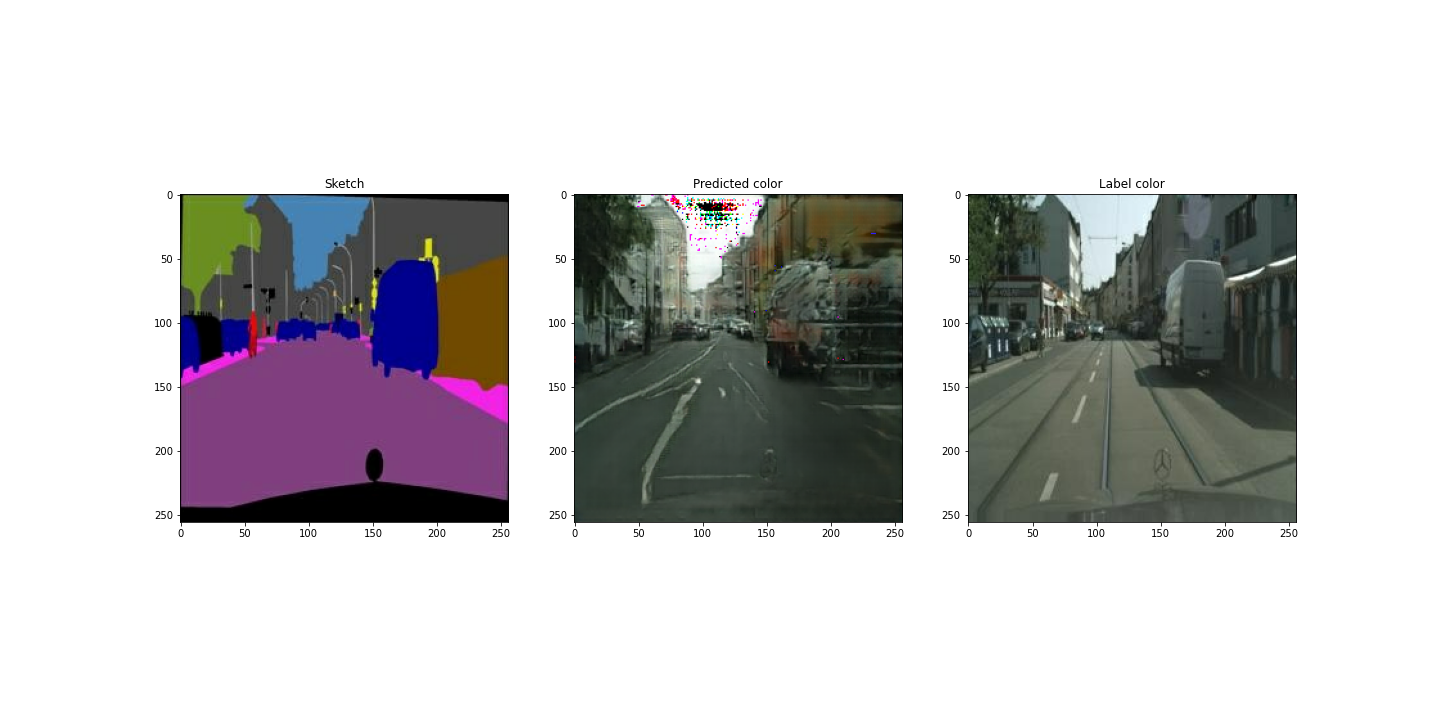
- Loss 값은 별로 중요하지 않은 것 같다. 그래프의 변화는 크게 없지만, 위의 450번째의 이미지보다 어색한 부분(여기서는 가운데 상단, 우측이 매우 어색하다)이 훨씬 줄어들었다.

# 완료